## Spatial Hot Spots

In the following, an attempt is made to classify the cab trips into clusters of start and end points using the processed dataset, with spatial hotspots can be identified.

The approach of soft clustering with GMM is used. The dataset is analyzed on the basis of the start and end points, since these can be different due to empty trips, which are not included in the dataset.

Only the sampled dataset with about 1% of the data is used because a calculation of the full dataset was not completed after more than 96 hours.

#### Imports and preparatory calculations
In the following, the necessary libraries are imported and the data set is loaded and displayed superficially.

Furthermore, preparatory calculations are performed to extracte the longitude and latitude .

In [1]:
# Import necessary libraries
import re
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

In [2]:
# Import dataset
trips_df = pd.read_parquet('../../data/rides/Taxi_Trips_Sampled_Cleaned.parquet') #Sampled
#trips_df = pd.read_parquet('../../data/rides/Taxi_Trips_Cleaned.parquet') #NonSampled

In [3]:
# General presentation of the dataframe
trips_df.info()
trips_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170568 entries, 0 to 170567
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   taxi_id                 170568 non-null  int64         
 1   trip_start_timestamp    170568 non-null  datetime64[ns]
 2   trip_end_timestamp      170568 non-null  datetime64[ns]
 3   trip_seconds            170568 non-null  float64       
 4   trip_miles              170568 non-null  float64       
 5   pickup_census_tract     170568 non-null  int64         
 6   dropoff_census_tract    170568 non-null  int64         
 7   pickup_community_area   170568 non-null  int64         
 8   dropoff_community_area  170568 non-null  int64         
 9   fare                    170568 non-null  float64       
 10  tips                    170568 non-null  float64       
 11  tolls                   170568 non-null  float64       
 12  Extras                  170568

,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,...,h3_07_dropoff,h3_08_pickup,h3_08_dropoff,h3_09_pickup,h3_09_dropoff,pickup_centroid,dropoff_centroid,datetime,temp,precip
0,1,2015-01-01 00:00:00,2015-01-01 00:00:00,540.0,0.17,17031080300,17031063301,8,6,7.25,...,872664c10ffffff,882664c13bfffff,882664c101fffff,892664c13afffff,892664c101bffff,POINT (-87.63576009 41.90749193),POINT (-87.643022804 41.934539716),2015-01-01,-7.0115,0
1,2,2015-01-01 00:00:00,2015-01-01 00:00:00,480.0,0.90,17031320100,17031081500,32,8,6.25,...,872664c1effffff,882664c1e3fffff,882664c1e1fffff,892664c1e2fffff,892664c1e0fffff,POINT (-87.620992913 41.884987192),POINT (-87.626214906 41.892507781),2015-01-01,-7.0115,0
2,3,2015-01-01 00:15:00,2015-01-01 00:30:00,780.0,5.50,17031281900,17031063301,28,6,14.05,...,872664c10ffffff,882664c1adfffff,882664c101fffff,892664c1acfffff,892664c101bffff,POINT (-87.642648998 41.879255084),POINT (-87.643022804 41.934539716),2015-01-01,-7.0115,0
3,4,2015-01-01 00:30:00,2015-01-01 00:45:00,780.0,2.30,17031062900,17031031400,6,3,8.85,...,872664d89ffffff,882664c163fffff,882664d893fffff,892664c162fffff,892664d8923ffff,POINT (-87.656411531 41.936237179),POINT (-87.645378762 41.962178629),2015-01-01,-7.0115,0
4,5,2015-01-01 00:00:00,2015-01-01 00:15:00,600.0,2.40,17031071500,17031070700,7,7,8.85,...,872664c12ffffff,882664c115fffff,882664c121fffff,892664c114fffff,892664c1257ffff,POINT (-87.631717366 41.914616286),POINT (-87.673807238 41.929272532),2015-01-01,-7.0115,0


#### Extract the longitude and latitude
First, we extract the longitude and latitude from the data to cluster based on them.  
This is done once for the pickup data and once for the dropoff data.

In [4]:
# Extract the longitude and latitude
def extract_coordinates(point):
    coords = re.findall(r"[-+]?\d*\.\d+|\d+", point)
    return [float(coord) for coord in coords]

trips_df['pickup_point'] = trips_df['pickup_centroid'].apply(extract_coordinates)
trips_df['dropoff_point'] = trips_df['dropoff_centroid'].apply(extract_coordinates)

pickup_coordinates = np.vstack(trips_df['pickup_point'].values)
dropoff_coordinates = np.vstack(trips_df['dropoff_point'].values)

### Determination of the hyperparameters

We would now like to set the hyperparameters for our GMM. This is first the number of clusters we want to find. Furthermore, the optimal bandwidth for the kernel density estimation has to be found. 

#### Calculation of the optimal number of clusters with the elbow method
First, we compute the inertia for up to 10 clusters and then use the visualization to select the optimal number of clusters at the point where an elbow can be seen.

In [5]:
n_components = np.arange(1, 10)

# Model for pickup
models_pickup = [GaussianMixture(n, covariance_type='full', random_state=0).fit(pickup_coordinates)
                 for n in n_components]
# Model for dropoff
models_dropoff = [GaussianMixture(n, covariance_type='full', random_state=0).fit(dropoff_coordinates)
                  for n in n_components]

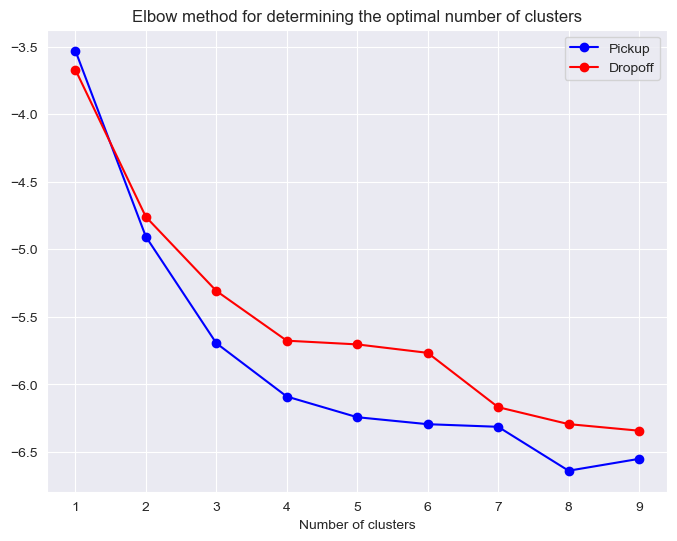

In [6]:
plt.figure(figsize=(8, 6))

# Plot pickup
plt.plot(n_components, [-m.score(pickup_coordinates) for m in models_pickup], color='blue', label='Pickup', marker='o')

# Plot dropoff
plt.plot(n_components, [-m.score(dropoff_coordinates) for m in models_dropoff], color='red', label='Dropoff', marker='o')

# Labeling and legend
plt.title('Elbow method for determining the optimal number of clusters')
plt.xlabel('Number of clusters')
plt.legend(loc='best')
plt.show()

It can be seen that the inertia does not decrease noticeably after 4 to 5 clusters. Therefore, 4 clusters are now calculated in K Means in order to further anlayze them.

#### Calculation of the optimal bandwith for KDE
Define a function, calculate_best_bandwidth, which determines the optimal bandwidth value for kernel density estimation by using GridSearchCV.Then calculates the best bandwidth values for both pickup and dropoff coordinates of trips.

In [7]:
def calculate_best_bandwidth(coordinates, bandwidths_range=(-1, 1, 10), cv=5, n_jobs=-1):
    # Calculate the optimal bandwidth
    bandwidths = 10 ** np.linspace(*bandwidths_range)

    # Generate a KernelDensity object
    kde = KernelDensity()

    # Use GridSearchCV to find the best bandwidth
    # Set n_jobs=-1 to use all available cores
    grid = GridSearchCV(kde, {'bandwidth': bandwidths}, cv=cv, n_jobs=n_jobs)  # Cross-validation
    grid.fit(coordinates)

    # Best bandwidth
    best_bandwidth = grid.best_params_['bandwidth']

    return best_bandwidth

# Calculate best bandwidth for pickup location
best_bandwidth_pickup = calculate_best_bandwidth(pickup_coordinates)
print("Best Bandwidth Pickup: ", best_bandwidth_pickup)

# Calculate best bandwidth for dropoff location
best_bandwidth_dropoff = calculate_best_bandwidth(dropoff_coordinates)
print("Best Bandwidth Dropoff: ", best_bandwidth_dropoff)

Best Bandwidth Pickup:  0.1
Best Bandwidth Dropoff:  0.1


#### Create a spatial kernel density estimate
Now we establishe a spatial kernel density estimation for both pickup and dropoff coordinates using a Gaussian kernel. Then, computes the density estimates for the data points of these coordinates.

In [8]:
# Create a spatial kernel density estimation
kde_pickup = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth_pickup).fit(pickup_coordinates)
kde_dropoff = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth_dropoff).fit(dropoff_coordinates)

# Calculate the density estimation for the data points
pickup_density = np.exp(kde_pickup.score_samples(pickup_coordinates))
dropoff_density = np.exp(kde_dropoff.score_samples(dropoff_coordinates))

## Gaussian Mixture Model

Now we create the GMM based on the KDE and calculate the spatial hotspot centers and their sizes

In [9]:
# Application of Gaussian mixed models to density estimation
gmm_pickup = GaussianMixture(n_components=4).fit(pickup_coordinates, pickup_density)
gmm_dropoff = GaussianMixture(n_components=4).fit(dropoff_coordinates, dropoff_density)

In [10]:
# Cache the results in variables
pickup_covariances = gmm_pickup.covariances_
dropoff_covariances = gmm_dropoff.covariances_
pickup_centers = gmm_pickup.means_
dropoff_centers = gmm_dropoff.means_

# Display the location (means) and size (variances) of the identified hotspots
print("Hotspot Centers (Pickup):", gmm_pickup.means_)
print("Hotspot Sizes (Pickup):", gmm_pickup.covariances_)
print("Hotspot Centers (Dropoff):", gmm_dropoff.means_)
print("Hotspot Sizes (Dropoff):", gmm_dropoff.covariances_)

Hotspot Centers (Pickup): [[-87.62848161  41.88854742]
 [-87.90303966  41.97907082]
 [-87.75093429  41.78599852]
 [-87.64382642  41.90454414]]
Hotspot Sizes (Pickup): [[[ 5.52677249e-05  1.39740990e-05]
  [ 1.39740990e-05  6.05022185e-05]]

 [[ 1.00000000e-06  5.93728272e-26]
  [ 5.93728272e-26  1.00000000e-06]]

 [[ 1.00000000e-06 -2.02509475e-17]
  [-2.02509475e-17  1.00000000e-06]]

 [[ 3.37946467e-04 -3.08790176e-04]
  [-3.08790176e-04  1.00445810e-03]]]
Hotspot Centers (Dropoff): [[-87.62845893  41.88851006]
 [-87.90303966  41.97907082]
 [-87.75093429  41.78599852]
 [-87.64636563  41.90550399]]
Hotspot Sizes (Dropoff): [[[ 5.77761042e-05  1.40400357e-05]
  [ 1.40400357e-05  6.60797763e-05]]

 [[ 1.00000000e-06 -7.21965500e-26]
  [-7.21965500e-26  1.00000000e-06]]

 [[ 1.00000000e-06  1.04704913e-23]
  [ 1.04704913e-23  1.00000000e-06]]

 [[ 4.17171625e-04 -3.28631778e-04]
  [-3.28631778e-04  1.07072205e-03]]]


## Visualization
Now we visualize the identified hotspots for both pickup and dropoff locations on a map centered around Chicago. Blue markers indicate pickup centers, while red markers represent dropoff centers. 

In [12]:
# Creating a map centered on Chicago
m = folium.Map(location=[41.8781, -87.6298], zoom_start=11, control_scale=False)

# Fetching the centers and covariances
pickup_centers = gmm_pickup.means_
dropoff_centers = gmm_dropoff.means_

# Adding markers for pickup centers
for center in pickup_centers:
    folium.Marker(location=[center[1], center[0]],
                  icon=folium.Icon(color='blue'),
                  popup='Pickup Center').add_to(m)

# Adding markers for dropoff centers
for center in dropoff_centers:
    folium.Marker(location=[center[1], center[0]],
                  icon=folium.Icon(color='red'),
                  popup='Dropoff Center').add_to(m)

# Display the map
m